In [169]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os
import plotly.express as px
from scipy.fft import fft, fftfreq
import statistics
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import *

from IPython.display import clear_output

import yaml
import json
import time
import joblib
import itertools
from collections import OrderedDict



#from wutils import *

def new_csv(csv=None,fault=None):
    df = pd.read_csv(csv)
    missing = []
    [missing.append(float(d)) for d in df.columns]
    df.columns = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']
    tempDf = pd.DataFrame(data=[missing],columns=df.columns,index=[0])
    df = pd.concat([tempDf,df],axis=0).reset_index().drop(columns=['index'])
    df['class'] = fault
    return df

# Check to see if a directory is a leaf or not. This is used later on for collecting data.
def is_leaf(path='.'):
    cwd = os.getcwd()
    os.chdir(path)
    check = sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower)
    os.chdir(cwd)
    if '.csv' in check[0]:
        return True
    else:
        return False
# Similar to reap_all_data() (found further down) but only collects vert simple data. Not used at the moment
def reap_stat_data(path='.', df=None, dictionary=None, columns=None):
    cwd = os.getcwd()
    os.chdir(path)
    files = sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower)
    for f in files:
        data = pd.read_csv(f)
        missing = []
        [missing.append(float(d)) for d in data.columns]
        data.columns = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']
        missingDf = pd.DataFrame(data=[missing],columns=data.columns,index=[0])
        data = pd.concat([missingDf,data],axis=0)
        stats = data.describe()
        stats = stats.drop(index=['count','25%','50%','75%'],axis=0)
        tempDf = pd.DataFrame(columns=df.columns)
        for col in columns[:-1]:
            tempDf[col] = [stats[col[:-3]].iloc[dictionary[col[-3:]]]]
        classStr = path.split('/')
        tempDf['class'] = classStr[5]
        df = pd.concat([tempDf,df],axis=0)
    os.chdir(cwd)
    return df.reset_index().drop(columns=['index'])

# def walk_dirs(columns=None,codes=None,inputFrame=None,
#               finalFrame=None, walkDir=None):

#     for root, subdirs, files in os.walk(walkDir):

#         list_file_path = os.path.join(root, '')

#         print(list_file_path)
#         if is_leaf(path=list_file_path):
#             print('leaf')
#             data = reap_all_data(path=list_file_path,df=inputFrame,
#                                   dictionary=codes,columns=columns)
#             finalFrame = pd.concat([finalFrame,data],axis=0)

#         else:
#             print('not a leaf')
#     return finalFrame.reset_index().drop(columns='index')

# Given a parent directory, scan all sub-directories for data files and consolidate rows using SUMMARY STATISTICS
#
def walk_all_dirs(inputFrame=None,finalFrame=None, walkDir=None):

    for root, subdirs, files in os.walk(walkDir):

        list_file_path = os.path.join(root, '')

        print(list_file_path)
        if is_leaf(path=list_file_path):
            print('leaf')
            data = reap_all_data(path=list_file_path,df=inputFrame)
            finalFrame = pd.concat([finalFrame,data],axis=0)

        else:
            print('not a leaf')
    return finalFrame.reset_index().drop(columns='index')

def list_all_files(walkDir=None):
    files = []
    for root, subdirs, files in os.walk(walkDir):

        list_file_path = os.path.join(root, '')

        print(list_file_path)
        if is_leaf(path=list_file_path):
            files.append(sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower))
            print('leaf')
        else:
            print('not a leaf')
    return files

# Given a raw signal and our sampling rate, figure out the fundamental frequency of the signal using the method
# laid out in the papers.
def estimate_fundamental_frequency(sample=None,samp_per_sec=None):

    # values of the tachometer signal
    y = np.array(sample)
    # sample rate
    T = 1/samp_per_sec

    # calculate the Discrete Fourier Transform of the tachometer signal and
    # return the x values (frequency (Hz)) and the y values (magnitude)
    xf, yf = do_fft(y=y,T=T)

#     print(f'FROM EFF -- len: {len(xf)}')

    # initialize empty list that will hold candidates for the fundamental
    # frequency
    candidates = []
    idxs = []

    # scan the DFT for frequencies that may be candidates for the fundamental frequency.
    # Once a candidate has been found, mask it and the surrouding area to hone in on another.
    # return the list of candidates along with the modified x and y values for the DFT.
    for i in range(4):
        # find the frequency with the highest magnitude and return the x and y values
        maxIdx, argmax = find_highest_frequency(xf,yf)
#         print(f'FROM EFF -- maxIdx: {maxIdx}')
        # store the value of this frequency in candidates
        candidates.append(argmax)
        idxs.append(maxIdx)
        # mask the located frequency and it's neighbors [-3,+3] with zeros
#         zone = yf[maxIdx-3:maxIdx+4]
#         print(zone.shape)
#         if zone.shape != (7,):
#             print(yf)
#         zone = np.zeros(7)

        lo = maxIdx-3
        hi = maxIdx+4

        # this covers the case where the argmax is {0,1,2} and would cause the initial index to be less than 0
        if lo < 0:
            lo-=lo

        # if everything is working as usual, width should be 7
        # else, width becomes a smaller value. This means we are zeroing out an area from [0,hi+1]
        width = hi-lo

        yf[lo:hi] = np.zeros(width)


#         yf[maxIdx-3:maxIdx+4] = np.zeros(7)

    return candidates, idxs, xf, yf

# Given the X and Y spectral coordinates, find the highest peak and return the magnitude and the frequency
def find_highest_frequency(xf=None,yf=None):

    maxIdx = np.argmax(yf)
    argmax = xf[maxIdx]

    return maxIdx, argmax

# Given a raw signal, for example the Tachometer Signal from full/normal/12.288.csv, and 1/(sampling frequency
# in Hz), return the X and Y coordinates of the spectrum. In our case, the sampling frequency is 50kHz, or 50000Hz
def do_fft(y=None,T=None):


    N = len(y)

    yf = fft(y)[0:N//2]
    xf = fftfreq(N,T)[:N//2]
    yf = 2.0/N * np.abs(yf)

    return xf, yf

# Given the X and Y coordinates gathered from the above function do_fft(), simply plot them out in an interactive
# manner using plotly
def plot_fft(xf=None,yf=None):

    f = pd.DataFrame(columns={'x','y'})
    f['x'] = xf
    f['y'] = yf
    fig = px.line(f,x='x',y='y', title='Spectral Analysis (FFT)',
                  labels=dict(
                         x='frequency',
                         y='magnitude')
                   )

    return fig

# Given a parent directory, scan for data files and consolidate all 250,000 rows in each file
# down to 1 using the supplied functions. This converts raw data into SUMMARY STATISTICS and should only be used
# when not wanting to work with the entire dataset. The data gathered from this might be useful just to get
# something running as a proof of concept, but it does take some time to consilidate all the data. Called by
# walk_all_dirs()
def reap_all_data(path='.', df=None):
    columns = df.columns
    cwd = os.getcwd()
    os.chdir(path)
    files = sorted([f for f in os.listdir('./') if not f.startswith('.')], key=str.lower)
    for f in files:
        data = pd.read_csv(f)
        missing = []
        [missing.append(float(d)) for d in data.columns]
        data.columns = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']
        missingDf = pd.DataFrame(data=[missing],columns=data.columns,index=[0])
        data = pd.concat([missingDf,data],axis=0)
        tempDf = pd.DataFrame(columns=df.columns)
        candidates, idxs, xf, yf= estimate_fundamental_frequency(sample=data['tachometerSignal'],
                                                                 samp_per_sec=50000)
        #print(np.min(candidates))

        #print(columns)
        for col in columns[:-2]:

            _col = col.split('-')
            #print(col)
            featureName = _col[0] # Ex: axialOverhang
            statName = _col[1]    # Ex: Mean
            #print(f'featureName: {featureName}')
            #print(f'statName: {statName}')

            if statName == 'Entropy':
                tempDf[col] = [stats.entropy(data[featureName].value_counts())]
                #break
            elif statName == 'Kurtosis':
                tempDf[col] = [stats.kurtosis(data[featureName])]
                #break
            elif statName == 'Mean':
                tempDf[col] = [np.mean(data[featureName])]
                #break
            ##############################################
            elif statName == 'Std':
                tempDf[col] = [np.std(data[featureName])]
                #break
            elif statName == 'Min':
                tempDf[col] = [np.min(data[featureName])]
                #break
            elif statName == 'Max':
                tempDf[col] = [np.max(data[featureName])]
                #break
            ##############################################
            elif statName == 'F':
                spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                     samp_per_sec=50000,
                                                     idxs=idxs)
                tempDf[col] = [spectrals[0][0]]
                #break
            elif statName == '2F':
                spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                     samp_per_sec=50000,
                                                     idxs=idxs)
                tempDf[col] = [spectrals[0][1]]
                #break
            elif statName == '3F':
                spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                     samp_per_sec=50000,
                                                     idxs=idxs)
                tempDf[col] = [spectrals[0][2]]
                #break
        classStr = path.split('/')
        tempDf['fundamentalFrequency'] = np.min(candidates)
        tempDf['path'] = os.getcwd().split('data/')[-1]+'/'+f
        tempDf['class'] = os.getcwd().split('full/')[-1]
        #print(tempDf.head())
        df = pd.concat([tempDf,df],axis=0)
    os.chdir(cwd)
    return df.reset_index().drop(columns=['index'])

# extract the spectral features laid out in the paper.
# given a sample, or in more exact terms, all of the rows corresponding to a single column in a data file,
# AKA a whole signal, take the FFT and find the magnitude of the spectrum at F, 2F, and 3F. F is the fundamental
# frequency of a signal and can be found by estimate_fundamental_frequency()
def extract_spectral_feature(sample=None,samp_per_sec=None,idxs=None):

    # do fft and return x and y coordinates
    xf,yf = do_fft(y=sample,T=1/samp_per_sec)

    # these are the candidates for the fundamental frequency and just so happen to be F, 2F, 3F, and 4F
    idxs.sort()

    # we only need F, 2F, and 3F
    spectrals = [yf[idxs[0]],
                 yf[idxs[1]],
                 yf[idxs[2]]]

    return spectrals, xf,yf

# not used. can find 2*F and 3*F with the candidates list
def find_nearest_peak(idx=None,yf=None):

    right = idx + 1
    left = idx - 1
    prev = idx

    if yf[right] > yf[left]:
        current = right
        while yf[current] > yf[prev]:
            current+=1
            prev+=1

    elif yf[left] > yf[right]:
        current = left
        while yf[current] > yf[prev]:
            current-=1
            prev-=1

    return prev

def list_all_files(walkDir=None):
    f = []
    for root, subdirs, files in os.walk(walkDir):

        list_file_path = os.path.join(root, '')

#         print(list_file_path)
        if is_leaf(path=list_file_path):
            t = sorted([f for f in os.listdir(list_file_path) if not f.startswith('.')], key=str.lower)
            [f.append(list_file_path+_) for _ in t]
#             f.append(t)
#             print(f'{list_file_path} -> leaf')
#         else:
#             print(f'{list_file_path} -> not a leaf')
    return f

# Plots a confusion matrix next to a histogram to show the ratio of TF/FP TN/FN after predicting with our
# classifier model. The purpose of the histogram is to show the distribution of each of the classes since there
# is some notable disparity in this dataset. Ex: normal only has 49 measurements wheres imbalance has 333
# measurements (data files)
# codes: classes get ingested by the classifier model as numerical values, so codes is just a dictionary that
# says which value corresponds to which class
def confusion_hist_plot(df=None,y_test=None,preds=None,codes=None):

    fig, ((ax1),(ax2)) = plt.subplots(1,2,figsize=(20,8),sharey=False)

    cm = confusion_matrix(y_test,preds,normalize='true')
    _cm = confusion_matrix(y_test,preds,normalize=None)
    sns.heatmap(cm, annot=_cm, cmap='Blues',ax=ax1)

    v = [*y_test.values]
    v.extend([*preds])
    v = [*set(v)]
    v = pd.Series(v).map(dict(map(reversed,codes.items())))
    keys_to_extract = v.values
    codes = {key: codes[key] for key in keys_to_extract}

    ax1.set_xticklabels(codes.keys(),rotation=45)
    ax1.set_yticklabels(codes.keys(),rotation=0)

    histData = pd.DataFrame(data=y_test,columns=[target])

    keyDf=histData[target].map(dict(map(reversed,codes.items())))
    orderedDf = pd.Categorical(keyDf,categories=[*codes.keys()],ordered=True)
    sns.histplot(y=orderedDf,ax=ax2,color='cornflowerblue',linewidth=1.75)
#     ax2.set_yticklabels(classDict.keys(),rotation=45)

    acc = accuracy_score(y_test,preds)
    plt.suptitle(f'Confusion Matrix With Supporting Histogram\naccuracy score: {acc:.4f}')
    return fig
#     fig.suptitle("Confusion Matrix With Supporting Histogram", fontsize=14)

def summarize(df=None,columns=None):
    columns = columns
    data = df.copy()
    tempDf = pd.DataFrame()
    classes = np.unique(data['class'])
#     print(classes)
#     print(data.index)

    if len(classes) > 1:
        tempDf['class'] = ['mixed']
    else:
        tempDf['class'] = [classes[0]]

    data = data.drop(columns=['class'])

    candidates, idxs, xf, yf= estimate_fundamental_frequency(sample=data['tachometerSignal'],
                                                             samp_per_sec=50000)
    #print(np.min(candidates))

    #print(columns)
    for col in columns[:-2]:

        _col = col.split('-')
        #print(col)
        featureName = _col[0] # Ex: axialOverhang
        statName = _col[1]    # Ex: Mean
        #print(f'featureName: {featureName}')
        #print(f'statName: {statName}')

        if statName == 'Entropy':
            tempDf[col] = [stats.entropy(data[featureName].value_counts())]
            #break
        elif statName == 'Kurtosis':
            tempDf[col] = [stats.kurtosis(data[featureName])]
            #break
        elif statName == 'Mean':
            tempDf[col] = [np.mean(data[featureName])]
            #break
        ##############################################
        elif statName == 'Std':
            tempDf[col] = [np.std(data[featureName])]
            #break
        elif statName == 'Min':
            tempDf[col] = [np.min(data[featureName])]
            #break
        elif statName == 'Max':
            tempDf[col] = [np.max(data[featureName])]
            #break
        ##############################################
        elif statName == 'F':
            spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                 samp_per_sec=50000,
                                                 idxs=idxs)
            tempDf[col] = [spectrals[0][0]]
            #break
        elif statName == '2F':
            spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                 samp_per_sec=50000,
                                                 idxs=idxs)
            tempDf[col] = [spectrals[0][1]]
            #break
        elif statName == '3F':
            spectrals = extract_spectral_feature(sample=np.array(data[featureName]),
                                                 samp_per_sec=50000,
                                                 idxs=idxs)
            tempDf[col] = [spectrals[0][2]]
            #break
#     classStr = path.split('/')
    tempDf['fundamentalFrequency'] = np.min(candidates)
#     path = np.unique(df['path'])
#     tempDf['path'] = path
#     tempDf['class'] = [p.split('full/')[-1] for p in path]
    #print(tempDf.head())
    return tempDf.reset_index().drop(columns=['index'])

def plot_window( df=None, n=2, back_colors=['r','b'],
                 trues=None, preds=None,
                 fig_size=(14,26), p_color='C0', t_color='C1',
                 p_alpha=0.8, t_alpha=0.4, class_dict=None,
                 window_width=10000, width_per_step=10000):

    data_reindexed = df.reset_index().drop(columns=['index'])
    l = len(data_reindexed)/n
    sigs = data_reindexed.columns[:-2]
    n_plots = len(sigs)+1

    fig = plt.figure()

    # to change size of subplot's
    # set height of each subplot as 8
    fig.set_figheight(16)

    # set width of each subplot as 8
    fig.set_figwidth(14)

    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=1, nrows=n_plots,
                             width_ratios=[1], wspace=0.5,
                             hspace=0.5, height_ratios= [*np.ones(n_plots-1)]+[2])

    for i in range(n_plots):
        tick = len(data_reindexed)/5
        xticks = np.arange(0,len(data_reindexed)+tick,tick)
        ax = fig.add_subplot(spec[i])
        if i < n_plots-1:
            ax.plot(data_reindexed[sigs[i]],label=sigs[i])
            for _ in range(n):
                ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
            ax.axvspan(50000,50000+window_width,facecolor='y',alpha=.35)
            ax.set_xticks(xticks)
            ax.set_xticklabels(['']*len(xticks))
        else:
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),preds,
#                        label='predicted class',facecolors='none',edgecolors=p_color,alpha=p_alpha)
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),trues,
#                        label='true class',facecolors='none',edgecolors=t_color,alpha=t_alpha)
            ax.scatter(np.arange(window_width,(l*n),width_per_step),preds,
                       label='predicted class',facecolors='none',edgecolors=p_color,alpha=p_alpha)
            ax.scatter(np.arange(window_width,(l*n),width_per_step),trues,
                       label='true class',facecolors='none',edgecolors=t_color,alpha=t_alpha)
            ax.set_yticks([*class_dict.values()])
            ax.set_yticklabels([*class_dict.keys()])
            ax.set_xticks(xticks)
            for _ in range(n):
                ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
        ax.legend()
    acc = accuracy_score(trues[trues!=6],pd.Series(preds)[trues!=6])
    fig.suptitle(f'\n\n\n\n{window_width} wide window and {width_per_step} width per step\nAccuracy: {round(acc*100,2)}%')
#     plt.show()
    return fig, acc

#     fig, axs = plt.subplots(n_plots,figsize=fig_size,sharex=True)

#     for i,ax in enumerate(axs):
#         if i < n_plots-1:
#             ax.plot(data_reindexed[sigs[i]],label=sigs[i])
#             for _ in range(n):
#                 ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
#             ax.axvspan(50000,10000,facecolor='y',alpha=.35)
#         else:
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),preds,
#                        label='predicted class',facecolors='none',edgecolors=p_color,alpha=p_alpha)
#             ax.scatter(np.arange(window_width,(l*n)+width_per_step,width_per_step),trues,
#                        label='true class',facecolors='none',edgecolors=t_color,alpha=t_alpha)
#             ax.set_yticks([*class_dict.values()])
#             ax.set_yticklabels([*class_dict.keys()])
#             for _ in range(n):
#                 ax.axvspan(l*_, (l*_)+l, facecolor=back_colors[_%2], alpha=0.13)
#         ax.legend()
    fig.suptitle(f'{window_width} window width and {width_per_step} width per step')

def prepare_window_data( data_path='~/ML/MAFAULDA/data/', steps_per_file=250000, num_files=2,
                         sensors=None, file_idxs=None ):
    df = pd.DataFrame(columns=sensors)
    val_files = pd.read_csv('./utils/val_files.csv').set_index('Unnamed: 0')

    if file_idxs is None:
        for i in range(num_files):
            p = data_path+val_files['path'].iloc[i]
            tempDf = pd.read_csv(p,header=None)
            tempDf.columns = sensors
            tempDf['path'] = [p]*steps_per_file
            tempDf['class'] = [p.split('full/')[-1].split('/')[0]]*steps_per_file
            df = pd.concat([df,tempDf])
    else:
        num_files = len(file_idxs)
        for i in file_idxs:
            p = data_path+val_files[val_files.index == i]['path'].values[0]
            tempDf = pd.read_csv(p,header=None)
            tempDf.columns = sensors
            tempDf['path'] = [p]*steps_per_file
            tempDf['class'] = [p.split('full/')[-1].split('/')[0]]*steps_per_file
            df = pd.concat([df,tempDf])

    return df

def slide_window( window_width=10000,width_per_step=10000,window_model=None,
                  num_files=2, df=None, columns=None, steps_per_file=250000 ):

    # sliding window hyper-parameters
#     window_width = 10000
#     width_per_step = 2500
#     window_model = model

    preds, trues = [],[]
#     for i in range(0,(steps_per_file*num_files)-window_width+width_per_step,width_per_step):
    for i in range(0,(steps_per_file*num_files)-window_width,width_per_step):
        data = df.iloc[i:i+window_width]
#         print(f'{i}:{i+window_width}')
        summarized = summarize(df=data,columns=columns)
        X = summarized.drop(columns=['class'])
        y = summarized['class'].map(classDict).values[0]
        pred = window_model.predict(X)[0]
        preds.append(pred)
        trues.append(y)

    # unique_values = []
    # unique_values.extend(preds)
    # unique_values.extend(trues)
    # unique_values = [*set(unique_values)]

    trues = pd.Series(trues)
    return trues, preds

def plot_feature_importance(model=None, X=None, figsize=None):
    feature_names = X.columns
    importance_frame = pd.DataFrame()
    importance_frame['Features'] = X.columns
    importance_frame['Importance'] = model.feature_importances_ #coef_
    importance_frame = importance_frame.sort_values(by=['Importance'], ascending=True)

    plt.figure(figsize=figsize)
    plt.barh(np.arange(1,len(X.columns)+1), importance_frame['Importance'], align='center', alpha=0.5)
    plt.yticks(np.arange(1,len(X.columns)+1), importance_frame['Features'])
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', titlesize=16)
    return importance_frame

def sweep_window(config='/Users/nrprzybyl/ML/MAFAULDA/window/config/config.yaml'):
    t = time.time()
    with open(config,'r') as stream:
        try:
            conf = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    with open('/Users/nrprzybyl/ML/MAFAULDA/window/utils/utils.json', 'r') as file:
        utils = json.load(file)

    # load the model
    model = joblib.load('./models/rfc.joblib')

    idxs = utils['idxs']
    S = utils['signals']
    columns = utils['columns']

    default = conf['default']
    plot_path = default['plot_path']
    experiment_name = default['experiment_name']
    path = os.path.join(plot_path,experiment_name)
    isDir = os.path.isdir(path)
    if not isDir:
        os.mkdir(path)

    sweep = conf['sweep']
    random_pick = sweep['random_pick']
    if not random_pick:
        file_idxs = sweep['file_idxs']
        n_files = len(file_idxs)
    else:
        n_files = sweep['n_files']
        file_idxs = [*np.random.choice([*idxs],n_files,replace=False)]
    width_per_step = sweep['width_per_step']
    window_width = sweep['window_width']
    wps = np.arange(width_per_step['lo'],width_per_step['hi']+width_per_step['step'],width_per_step['step'])
    ww = np.arange(window_width['lo'],window_width['hi']+window_width['step'],window_width['step'])
    params = [*itertools.product(wps,ww)]
    n_iters = len(params)

    meta = {}

    for i,p in enumerate(params):
        df = prepare_window_data(sensors=S, file_idxs=file_idxs)

        _width_per_step = p[0]
        _window_width = p[1]

        if i % 1 == 0:
            clear_output(wait=True)
            print(f'{i+1}/{n_iters} -- {round(100*((i+1)/(n_iters)),2)}%')

        _t = time.time()
        trues, preds = slide_window(window_model=model, df=df, columns=columns, num_files=n_files, width_per_step=_width_per_step, window_width=_window_width)
        _t = time.time() - _t

        overall_acc = accuracy_score(trues,preds)

        ######################################################

        t_zones = [ [] for _ in np.ones(n_files) ]
        p_zones = [ [] for _ in np.ones(n_files) ]

        zone_idxs = [ int((i*wps) // 250000) for i in range(len(trues)) ]

#         print(zone_idxs)
        for i,z in enumerate(zone_idxs):
#             print(z)
            p_zones[z].append(preds[i])
            t_zones[z].append(trues[i])

#         print(t_zones)
#         print(p_zones)

        ######################################################

        zones = []

        fig, acc = plot_window(df,trues=trues,preds=preds,class_dict=classDict, n=n_files, width_per_step=_width_per_step, window_width=_window_width)
        fig_name = ''
        for _ in file_idxs:
            fig_name+=f'{_}_'
        p = os.path.join(path,f'{_window_width}_{_width_per_step}')
        isDir = os.path.isdir(p)
        if not isDir:
            os.mkdir(p)
        run = f'{_window_width}_{_width_per_step}'
        fig_path = f'{path}/{run}/{fig_name[:-1]}'
        fig.savefig(fig_path)
        plt.close()

        fig1 = confusion_hist_plot(df=df,y_test=trues,preds=preds,codes=classDict)
        fig1.savefig(f'{fig_path} confusion.png')
        plt.close()

        meta[run] = {}
        meta[run]['overall_acc'] = overall_acc
        meta[run]['acc'] = acc

        meta[run]['time'] = _t

        ######################################################

        meta[run]['zones'] = {}
        meta[run]['zones'] = [ {} for _ in np.ones(n_files) ]
        for i in range(n_files):
            meta[run]['zones'][i]['acc'] = accuracy_score(t_zones[i],p_zones[i])

    file_paths = [*df['path'].unique()]
    meta[run]['file_paths'] = file_paths

        ######################################################

    t = time.time() - t
    meta[run]['time'] = t
    with open(f'{path}/out', 'w') as file:
        file.write(json.dumps(meta))

# Read in summarized MaFaulDa data

In [6]:
df = pd.read_csv('/Users/nrprzybyl/ML/MAFAULDA/data/complex_mafaulda_1sec.csv').drop('startPoint',axis=1)
df.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency,class,path
0,10.633214,0.004950,0.009842,0.156278,0.101619,0.122819,10.463767,-0.110942,-0.009464,0.020566,...,0.012263,0.022078,0.008598,0.021983,9.656114,1.898132,0.004390,61.00000,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
1,10.628957,0.194001,0.008607,0.162711,0.167297,0.163898,10.505807,0.407069,0.017773,0.023624,...,0.011990,0.021764,0.009035,0.021343,9.658679,2.001966,-0.006402,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
2,10.624347,-0.220687,0.009522,0.159777,0.133762,0.045357,10.473719,-0.221713,-0.000486,0.010891,...,0.011806,0.021401,0.008802,0.020001,9.643273,1.864986,0.004954,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
3,10.620357,-0.254865,0.009031,0.162775,0.093203,0.075060,10.451755,-0.086090,-0.012446,0.016143,...,0.012013,0.022151,0.010173,0.021473,9.649679,1.952311,-0.007070,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
4,10.631042,-0.154502,0.008411,0.168113,0.088672,0.106329,10.447604,-0.386185,0.026383,0.015667,...,0.011881,0.022520,0.009568,0.022267,9.644393,1.889186,0.006114,60.99878,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv


# Create a dictionary that maps fault types to integer values
    - add a "mixed" class for when a window is hovering over two distinct fault types

In [7]:
# make our class dictionary
keys = list(np.unique(df['class']))
codes = [int(_) for _ in np.arange(0,len(keys))]
classDict = dict(zip(keys,codes))
classDict['mixed'] = 6
classDict

{'horizontal-misalignment': 0,
 'imbalance': 1,
 'normal': 2,
 'overhang': 3,
 'underhang': 4,
 'vertical-misalignment': 5,
 'mixed': 6}

## create a new column that is the integer representation of class strings

In [8]:
df['CLASS'] = df['class']
df['class'] = df['class'].map(classDict)

# Train test split (80/20)

In [9]:
X = df.drop(columns=['class','path','CLASS'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=45,
                                                    stratify=None)

# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5,
#                                                  shuffle=True, random_state=45,
#                                                  stratify=None)
print(f'Length of train set: {len(X_train)}')
print(f'Length of test set: {len(X_test)}')
# print(f'Length of validation set: {len(X_val)}')

Length of train set: 7804
Length of test set: 1951


# Keep track of the indices of each raw data file from the summarized dataset

In [10]:
# These indices tell us which files we will need to pull from to re-summarize subsamples of the data for
# our sliding window

idxs = X_test.index
idxs = [int(_) for _ in idxs]

## (This is old, back when I was doing a 80/10/10 split) Here we are defining a Random Forest model and fitting it to our training set (80%). After the model is trained, we will get a baseline measurement of accuracy by utilizing our test set (10%). We will then use the indices of the validation set (10%) to tell us which data files we have not used up to this point. With this subset of data, we can re-summarize on smaller intervals of time (not the whole 5 seconds) and run those new data points through the model.

['./models/rfc_1sec.joblib']

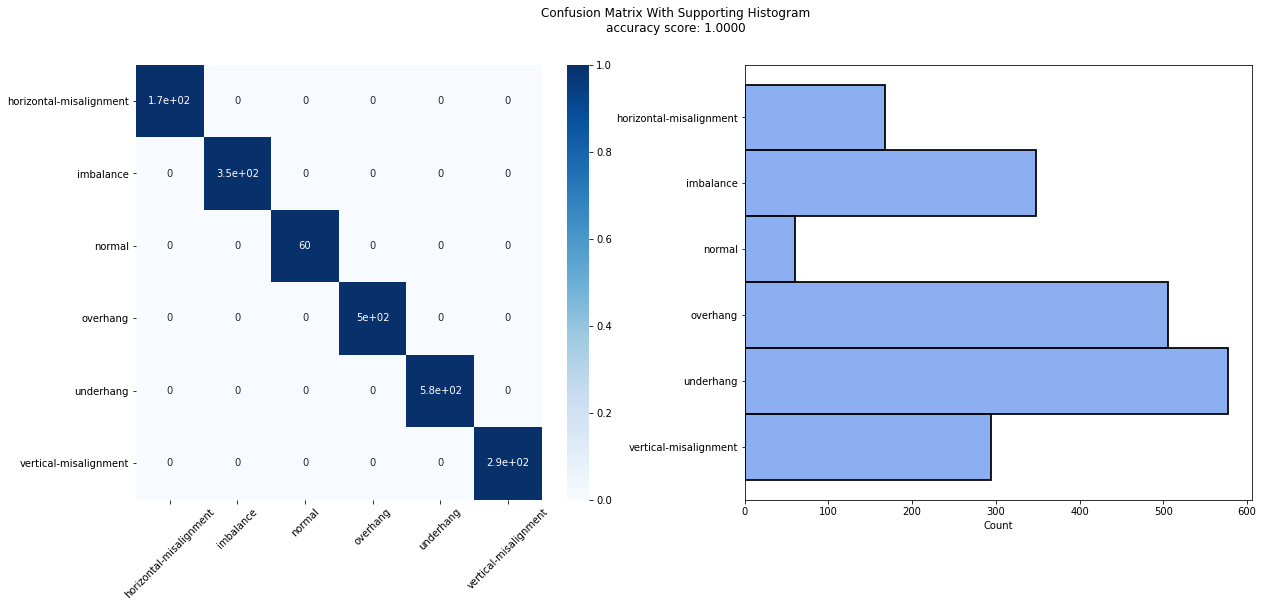

In [15]:
# used by the confusion_hist_plot function
target = 'class'

define the model
# model = RandomForestClassifier(bootstrap=True)

# load the model
# model = joblib.load('./models/rfc_1sec.joblib')

# fit the model with our training data
model.fit(X_train,y_train)
# try to predict the data points we set aside for testing
preds = model.predict(X_test)

#plot our results
confusion_hist_plot(df=df,y_test=y_test,preds=preds,codes=classDict);

# save our model
# commented out so current model doesn't get overwritten
# joblib.dump(model, "./models/rfc_1sec.joblib")

## "val_files" is a dataframe that will keep track of the following for the raw data files from the original summarized dataset:
    - source path
    - class
        - string representation
        - integer representation
    - index

In [36]:
val_files = df[['path','class','CLASS']].iloc[idxs]
val_files.head()
val_files.to_csv('./utils/test_files_1sec.csv')

In [42]:
val_files = pd.read_csv('./utils/test_files_1sec.csv').set_index('Unnamed: 0')

## Set up some variables that are important for summarizing raw data

In [37]:
# define each column as they are found in the raw data files
S = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']

# which statistical values we want to summarize from the raw data
Stats = ['-Entropy','-Kurtosis','-Mean','-F','-2F', '-3F'] # '-Std'

# which signals we want to apply the above statistics to. As per the paper, find the magnitude of the spectrum at
# F, 2F, and 3F for all signals other than the tachometer. That is why the tachometer is missing from this list.
Signals = ['axialUnderhang', 'axialOverhang','radialUnderhang',
          'radialOverhang','tangentialUnderhang','tangentialOverhang',
           'microphone']

# while we don't want the magnitude of the spectrum at F, 2F, and 3F for the tachometer, we DO want the other
# statistical features. So we add them here alongside the fundamental frequency and class label.
Others = ['tachometerSignal-Entropy','tachometerSignal-Kurtosis','tachometerSignal-Mean',
          #'tachometerSignal-Std','tachometerSignal-Min','tachometerSignal-Max',
          'fundamentalFrequency','class']

# create combinations of Signals and Stats to generate our feature names for summarization 
columns = [*itertools.product(Signals,Stats)]
for i,col in enumerate(columns):
    columns[i] = col[0]+col[1]
    
# add the other feature names to the final list of our columns
columns = columns + Others

## "utils" is a dictionary that keeps track of the following metadata:
    - the names of the columns from the raw data files (signals)
    - the names of teh columns used for feature extraction when summarizing raw data (columns)
    - a dictionary containing a mapping of fault names to integer values (classes)
    - a list of indices corresponding to individual raw data files from the original summarized dataset (idxs)

In [38]:
utils = {}
utils['signals'] = S
utils['columns'] = columns
utils['classes'] = classDict
utils['idxs'] = idxs
with open('./utils/utils_1sec.json', 'w') as file:
    file.write(json.dumps(utils))

In [43]:
with open('./utils/utils_1sec.json', 'r') as file:
    utils = json.load(file)

# open an example config file and print it out to see the basic information contained in a config file

In [46]:
with open('./config/config.yaml','r') as stream:
    try:
        conf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
conf

{'default': {'plot_path': '/Users/nrprzybyl/ML/MAFAULDA/window/plots/',
  'experiment_name': 'test1'},
 'sweep': {'random_pick': True,
  'n_files': 10,
  'file_idxs': [1396, 502, 1418, 990, 1420, 1823, 1408, 1296, 1402, 144],
  'width_per_step': {'lo': 2500, 'hi': 7500, 'step': 500},
  'window_width': {'lo': 10000, 'hi': 100000, 'step': 10000}}}

# using the template config file (above), modify values to your liking and quickly create new config files

In [48]:
names = ['all_underhangs','all_overhangs','all_imbalance','all_vertical_misalignments','all_horizontal_misalignments','all_normals']
classes = ['underhang','overhang','imbalance','vertical-misalignment','horizontal-misalignment','normal']
tag = '2500_250k_1sec'
for i,n in enumerate(names):
    conf['default']['experiment_name'] = f'{n}_{tag}'
    conf['default']['plot_path'] = '/ac-project/nprzybylski/window/plots/'
    conf['sweep']['random_pick'] = False
    conf['sweep']['file_idxs'] = [*val_files[val_files['CLASS'] == classes[i]].index]
    conf['sweep']['width_per_step']['lo'] = 2500
    conf['sweep']['width_per_step']['hi'] = 2500
    conf['sweep']['window_width']['lo'] = 5000
    conf['sweep']['window_width']['hi'] = 250000
    conf['sweep']['window_width']['step'] = 5000
    
    with open(f'./config/{n}_{tag}.yaml', 'w') as f:
        yaml.dump(conf, f)

In [ ]:
t = {}
t['zones'] = [ {} for _ in np.ones(4) ]
for i in range(4):
    
    t['zones'][i]['acc'] = 1
t

# define a list of directories to read output files from and collect accuracies from them

In [184]:
dirs = ['all_normals','all_overhangs','all_vertical_misalignments','all_horizontal_misalignments','all_imbalance','all_underhangs']
labels = ['normal','overhang','vertical-misalignment','horizontal-misalignment','imbalance','underhang']
accs = []
for d in dirs:
    try:
        with open(f'plots/{d}_2500_250k/out','r') as file:
            t = json.load(file)
            for key in sorted(t):
                t[int(key.split('_')[0])] = t.pop(key)
            t = OrderedDict(sorted(t.items(), key=lambda t: t[0]))
            accs.append([t[_]['acc'] for _ in t])
#             accs.append([t[_]['acc'] for _ in t])
    except Exception as e:
        print(e)
accs = np.array(accs)

In [89]:
np.mean(accs[:,-1])

0.7924986787458491

In [185]:
accs

array([[0.14613181, 0.28017241, 0.36743516, 0.35404624, 0.37101449,
        0.38372093, 0.40816327, 0.43567251, 0.42082111, 0.39852941,
        0.43510324, 0.39940828, 0.35459941, 0.40178571, 0.4119403 ,
        0.36077844, 0.3993994 , 0.43072289, 0.36404834, 0.38333333,
        0.43768997, 0.42530488, 0.42201835, 0.42791411, 0.42307692,
        0.39814815, 0.38544892, 0.40217391, 0.41744548, 0.3734375 ,
        0.39811912, 0.36006289, 0.36435331, 0.38449367, 0.34285714,
        0.34872611, 0.38817891, 0.34134615, 0.31350482, 0.35967742,
        0.34304207, 0.30844156, 0.34690554, 0.36111111, 0.35737705,
        0.34868421, 0.3679868 , 0.3294702 , 0.35548173, 0.355     ],
       [0.41065885, 0.64440994, 0.78719365, 0.80283149, 0.82452504,
        0.86143746, 0.87435188, 0.86151452, 0.89986164, 0.88062284,
        0.90758048, 0.91014543, 0.91392449, 0.94455994, 0.92668977,
        0.95128294, 0.92854665, 0.92106176, 0.95088511, 0.96961806,
        0.96613407, 0.95969423, 0.97810219, 0.9

In [186]:
# labels = ['normal','vertical-misalignment','horizontal-misalignment','imbalance','underhang']
print(f'average accuracy across all zones for window width of 250,000\n---------------------------------')
for i,a in enumerate(accs):
    print(f'{labels[i]}: {round(a[-1],4)}')
print(f'---------------------------------\naverage accuracy for all classes: {round(np.mean(accs[:,-1]),4)}')

average accuracy across all zones for window width of 250,000
---------------------------------
normal: 0.355
overhang: 0.9616
vertical-misalignment: 0.9742
horizontal-misalignment: 0.7564
imbalance: 0.7996
underhang: 0.9081
---------------------------------
average accuracy for all classes: 0.7925


In [187]:
# labels = ['normal','vertical-misalignment','horizontal-misalignment','imbalance','underhang']
print(f'average accuracy across all zones for window width of 250,000\n---------------------------------')
for i,a in enumerate(accs_1sec):
    print(f'{labels[i]}: {round(a[-1],4)}')
print(f'---------------------------------\naverage accuracy for all classes: {round(np.mean(accs_1sec[:,-1]),4)}')

average accuracy across all zones for window width of 250,000
---------------------------------
normal: 0.2566
overhang: 0.959
vertical-misalignment: 0.8761
horizontal-misalignment: 0.6553
imbalance: 0.5724
underhang: 0.7016
---------------------------------
average accuracy for all classes: 0.6702


In [ ]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(accs_1sec[:,:10]):
    ax.plot(a,label=labels[i])
plt.legend()
l=np.arange(5000,55000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('Model Accuracy as a Result of Window Width',fontdict={'size':14});
# plt.locator_params(axis='x', nbins=5)

# plot out model accuracy as a result of window width
    - still messing with x-axis, would like it to read:
        - 1s, 2s, 3s, 4s, 5s

In [98]:
accs_1sec[:,25]

array([0.89983278, 0.99276941, 0.99492852, 0.9381295 , 0.96230592,
       0.96367892])

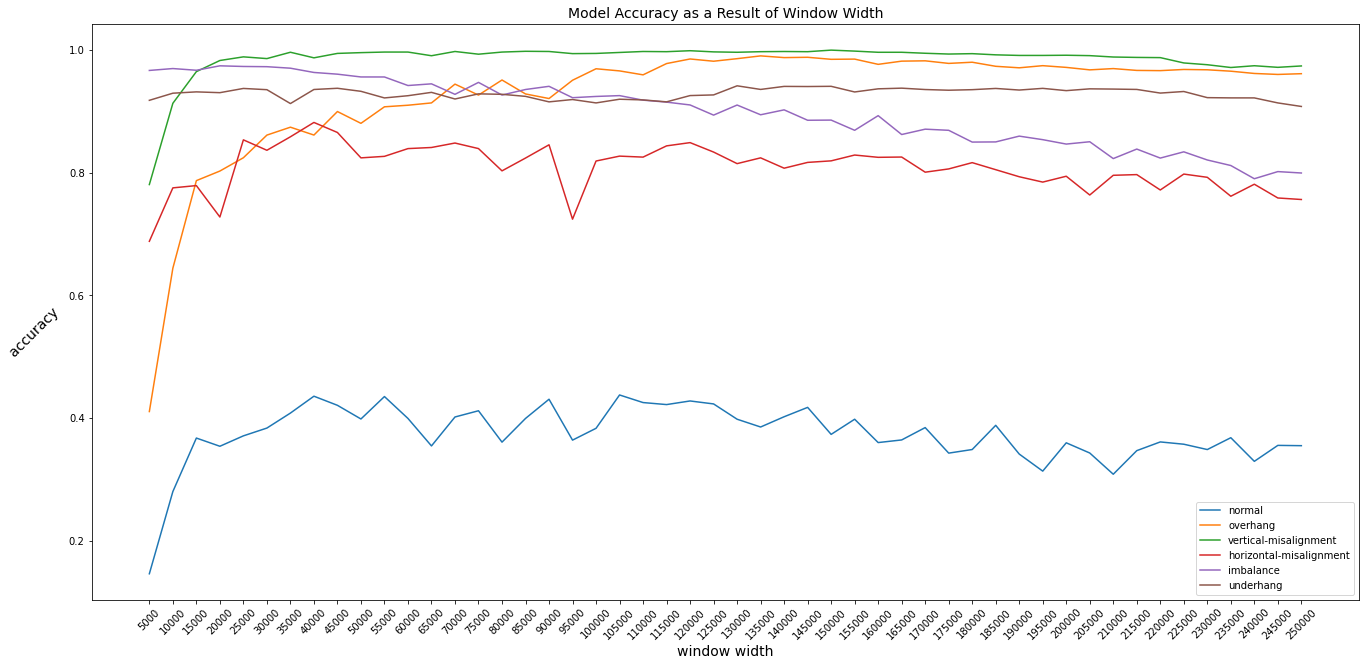

In [188]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(accs):
    ax.plot(a,label=labels[i])
plt.legend()
l=np.arange(5000,255000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('Model Accuracy as a Result of Window Width',fontdict={'size':14});
# plt.locator_params(axis='x', nbins=5)

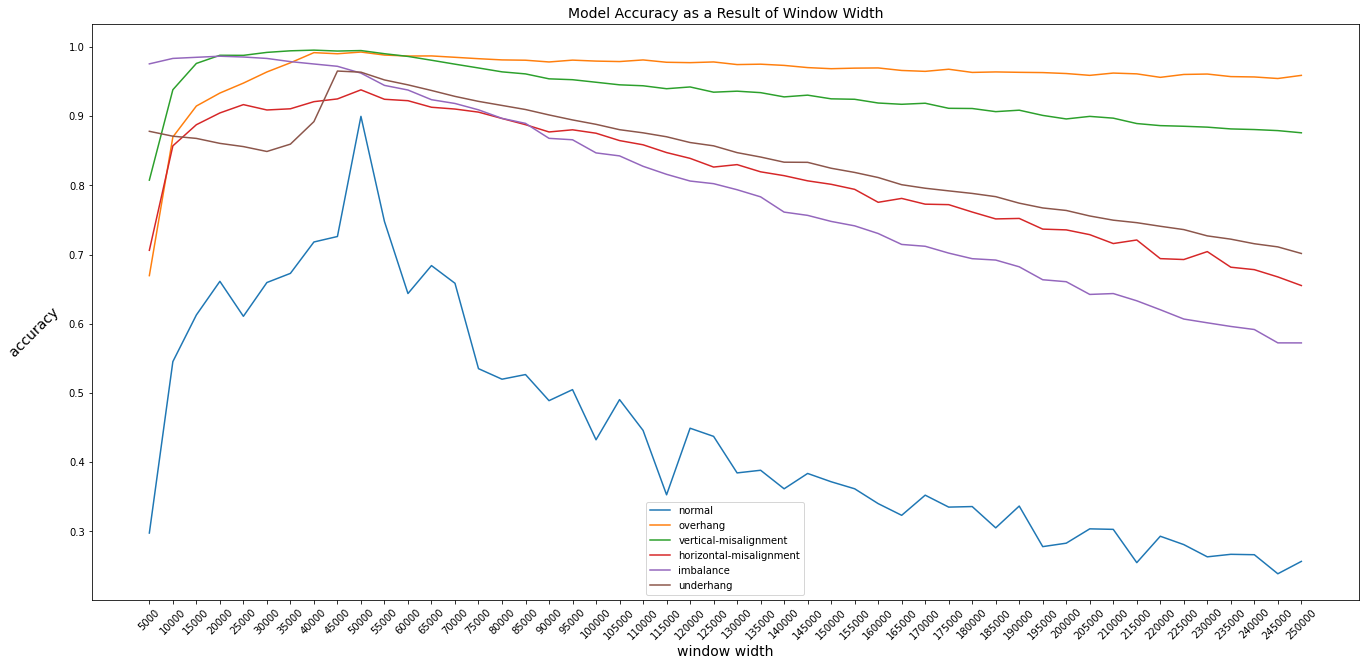

In [189]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(accs_1sec):
    ax.plot(a,label=labels[i])
plt.legend()
l=np.arange(5000,255000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('Model Accuracy as a Result of Window Width',fontdict={'size':14});
# plt.locator_params(axis='x', nbins=5)


# brainstorming ideas for output

## Data to save after each run

        - accuracy
            - overall (maybe)
            - minus "mixed" areas (current)
            - per zone
            - per class (maybe save confusion matrix for this part)
            
        - metadata (by zone)
            - source file path
                - class
                - weight/misalignment/rpm/type of fault(ball, outer race, cage)

## Example output

In [464]:
from pprint import pprint
test1 = {   
    '1000_10000': {
        'overall_acc': 30,
        'acc': 35,
        'zones': {
            '1': { 'acc': 40, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 30, 'path': 'full/normal/12.288.csv' }
        }
    },
    '2000_10000': {
        'overall_acc': 40,
        'acc': 45,
        'zones': {
            '1': { 'acc': 50, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 40, 'path': 'full/normal/12.288.csv' }
        }
    }
}
pprint(test1)

{'1000_10000': {'acc': 35,
                'overall_acc': 30,
                'zones': {'1': {'acc': 40,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 30, 'path': 'full/normal/12.288.csv'}}},
 '2000_10000': {'acc': 45,
                'overall_acc': 40,
                'zones': {'1': {'acc': 50,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 40, 'path': 'full/normal/12.288.csv'}}}}
